In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %pip install pandas==1.5.1

# Farmland & Crops Keras EfficientNet Multi-Class Classification

## Import Package


In [1]:
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [3]:
from utils.metrics import evaluate
from utils.image import load_image_and_resize

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [4]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Sun Dec 18 20:41:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P2    27W / 160W |   1096MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Const & Inputs

Here are all of the parameters to change for the run.


In [6]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn"

# Folder of the training data
training_folder = 'D:/Dataset/aidea-farmland-crops-autumn/train'

# Folder of the public data
public_folder = 'D:/Dataset/aidea-farmland-crops-autumn/public'

# Folder of the private data
private_folder = 'D:/Dataset/aidea-farmland-crops-autumn/private'

# Number of classes in the dataset
num_classes = 33

# Image size for model
image_size = 224

# options: (subset, fullset)
train_mode = 'fullset'

# options: (crop70xy, correct_by_rule, crop70xy_correct_by_rule)
image_preprocessing_method ="crop70xy_correct_by_rule"

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data
The training set has been randomly split into train (85%) and valid (15%) in advance.

In [33]:
data = pd.read_pickle(F'{path}/data/train_split_{train_mode}.pkl')
train = data[data['set_name'].eq('train')].reset_index(drop=True)
valid = data[data['set_name'].eq('valid')].reset_index(drop=True)
test = data[data['set_name'].eq('test')].reset_index(drop=True)
print(F"data: {data.shape}, train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

data: (89514, 21), train: (62670, 21), valid: (13390, 21), test: (13454, 21)


### Encode categorical features

OneHotEncoder

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data['label'].values.reshape(-1, 1))
train['class'] = list(np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist()))
valid['class'] = list(np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist()))
test['class'] = list(np.array(enc.transform(test['label'].values.reshape(-1, 1)).toarray().tolist()))

### Load Image Vector
We can choose to process the data from scratch, or read data that has already been processed.

In [42]:
# train = pd.read_pickle(F'{path}/data/{train_mode}_train_vector_{image_size}_{image_preprocessing_method}.pkl')
# valid = pd.read_pickle(F'{path}/data/{train_mode}_valid_vector_{image_size}_{image_preprocessing_method}.pkl')
# test = pd.read_pickle(F'{path}/data/{train_mode}_test_vector_{image_size}_{image_preprocessing_method}.pkl')

In [ ]:
# train
tqdm.pandas() #pd.to_pickle(train, F'{path}/data/{train_mode}_train_vector_{image_size}_{image_preprocessing_method}.pkl', protocol=4)
train["vector"] = train.progress_apply(lambda row: load_image_and_resize(F'{training_folder}/{row["label"]}/{row["file"]}', new_size=224, 
    resize_method="crop", crop_ratio=0.7, crop_center=(row['target_y'], row['target_x']), rotate=row['angle'] > 70), axis=1)
tqdm.pandas() # pd.to_pickle(valid, F'{path}/data/{train_mode}_valid_vector_{image_size}_{image_preprocessing_method}.pkl', protocol=4)
# valid
valid["vector"] = valid.progress_apply(lambda row: load_image_and_resize(F'{training_folder}/{row["label"]}/{row["file"]}', new_size=224, 
    resize_method="crop", crop_ratio=0.7, crop_center=(row['target_y'], row['target_x']), rotate=row['angle'] > 70), axis=1)
# test
tqdm.pandas() # pd.to_pickle(test, F'{path}/data/{train_mode}_test_vector_{image_size}_{image_preprocessing_method}.pkl', protocol=4)
test["vector"] = test.progress_apply(lambda row: load_image_and_resize(F'{training_folder}/{row["label"]}/{row["file"]}', new_size=224, 
    resize_method="crop", crop_ratio=0.7, crop_center=(row['target_y'], row['target_x']), rotate=row['angle'] > 70), axis=1)

### Prepare X and Y
We only need vector and class for training.

In [12]:
train_vector, train_class = np.array(train['vector'].tolist()), np.array(train['class'].tolist()) 
valid_vector, valid_class = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()) 
test_vector, test_class = np.array(test['vector'].tolist()), np.array(test['class'].tolist())

## Model Helper
reducelr, checkpoint, earlystop

In [17]:
def get_reducelr():
    return tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.5e-7,
    )

In [19]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
    )

In [20]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [23]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

In [7]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    # augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    # augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

In [8]:
def get_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB7(input_shape=input_shape, include_top=False, weights='imagenet', drop_connect_rate=dropout))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)
    return model  

In [10]:
# [10, 30, 50, 100, 150]
EPOCHS = 100

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

# dropout rate
DROPOUT = 0.4

# Define model name
model_name = F'{train_mode}_{input_shape[0]}_{image_preprocessing_method}_efficientnetb7_transfer_trainable_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}'

# Check model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    # stop training if model is exist
    raise SystemExit(F'{model_name} is exist')

### Modelling

In [26]:
# Dataset to train
train_ds, valid_ds = get_batch_dataset(train_vector, train_class, valid_vector, valid_class, BATCH_SIZE)

In [11]:
with strategy.scope():    
    model = get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=False)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=valid_ds,
  verbose=2,
  callbacks=[
    get_checkpoint(F'{path}/models/{model_name}.h5', 'val_categorical_accuracy'), 
    get_early_stop(50),
    get_reducelr(),
  ],
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))
# get_batch_dataset(subset),  B3, TPU: 122s (16s after the 2nd EPOCH)
# get_batch_dataset(subset),  B3, Low-GPU: 235s
# get_batch_dataset(subset),  B3, High-GPU: 133s
# get_batch_dataset(fullset), B7, High-GPU: 835s

epochs:  52


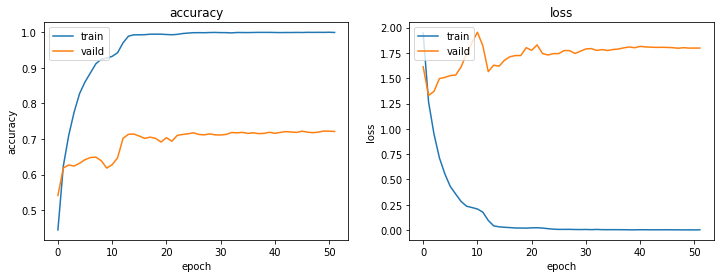

In [29]:
log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(log['categorical_accuracy'])
plt.plot(log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(log['loss']) 
plt.plot(log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Save image
plt.savefig(F'{path}/logs/{model_name}.jpg')

### Prediction of vaild
Prediction based on the best model during training

In [49]:
# evaluations = pd.read_csv(F'{path}/classification_multiclass_efficientnet_evaluations.csv')
# evaluations = evaluations.sort_values('test.precision', ascending=False).reset_index(drop=True)
# best_model = evaluations.iloc[1]['experiment']

In [31]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.load_weights(F'{path}/models/{model_name}.h5')

In [32]:
# Predict the response for train dataset
train['predict'] = list(model.predict(train_vector, verbose=1))
train['predict_label'] = enc.inverse_transform(train['predict'].tolist()).reshape(-1)
# Predict the response for valid dataset
valid['predict'] = list(model.predict(valid_vector, verbose=1))
valid['predict_label'] = enc.inverse_transform(valid['predict'].tolist()).reshape(-1)
# Predict the response for test dataset
test['predict'] = list(model.predict(test_vector, verbose=1))
test['predict_label'] = enc.inverse_transform(test['predict'].tolist()).reshape(-1)
# Save result
result = pd.concat([train, valid, test], ignore_index=True).drop_duplicates(subset=['target_fid'], ignore_index=True)
result = result[['file', 'label', 'height', 'width', 'target_fid', 'target_x', 'target_y', 'county_name', 'town_name', 'town_x', 'town_y', 'town_z', 'set_name', 'predict', 'predict_label']]
result.to_pickle(F'{path}/outputs/train/{model_name}.pkl', protocol=4)

85/85 [==============================] - 10s 119ms/step


In [ ]:
result = pd.read_pickle(F'{path}/outputs/train/{model_name}.pkl')

# Evaluate: calculate train accuracy
train = result[result['set_name'].eq('train')].reset_index(drop=True)
train_evaluation = evaluate(train['label'].tolist(), train['predict_label'].tolist())['weighted avg']
train_evaluation = {F'train.{key}': value for key, value in train_evaluation.items()}
# Evaluate: calculate valid accuracy
valid = result[result['set_name'].eq('valid')].reset_index(drop=True)
valid_evaluation = evaluate(valid['label'].tolist(), valid['predict_label'].tolist())['weighted avg']
valid_evaluation = {F'valid.{key}': value for key, value in valid_evaluation.items()}
# Evaluate: calculate test accuracy
test = result[result['set_name'].eq('test')].reset_index(drop=True)
test_evaluation = evaluate(test['label'].tolist(), test['predict_label'].tolist())['weighted avg']
test_evaluation = {F'test.{key}': value for key, value in test_evaluation.items()}
# evaluation = pd.DataFrame([{'experiment': model_name, 'data': train_mode, 'datetime': datetime.datetime.now(), 'spend(s)': round(end-start), 'epochs': len(history), **train_evaluation, **valid_evaluation, **test_evaluation}])
evaluation = pd.DataFrame([{'experiment': model_name, 'data': train_mode, 'datetime': datetime.datetime.now(), **train_evaluation, **valid_evaluation, **test_evaluation}])

In [39]:
evaluations = pd.read_csv(F'{path}/classification_multiclass_efficientnet_evaluations.csv')
evaluations = evaluations.append(evaluation).sort_values('valid.precision', ascending=False).reset_index(drop=True)
evaluations.to_csv(F'{path}/classification_multiclass_efficientnet_evaluations.csv', index=False)
evaluations.head(5)[['experiment', 'test.precision']]

,experiment,valid.precision
0,subset_224_correct_by_rule_efficientnetb3_tran...,0.722410
1,subset_224_efficientnetb3_transfer_trainable_e...,0.720000
2,subset_224_efficientnetb3_transfer_trainable_e...,0.717800
3,subset_224_crop70_efficientnetb3_transfer_trai...,0.716800
4,subset_224_correct_by_rule_efficientnetb3_tran...,0.716464


### Prediction of public
Prediction based on the best model during training

In [5]:
public = pd.read_csv(F'{path}/data/public_tag_loc_coor_describe_elevation.csv')
# public = pd.read_pickle(F'{path}/data/public_vector_{image_size}_{image_preprocessing_method}.pkl')

In [57]:
tqdm.pandas() #pd.to_pickle(public, F'{path}/data/public_vector_{image_size}_{image_preprocessing_method}.pkl', protocol=4)
public["vector"] = public.progress_apply(lambda row: load_image_and_resize(F'{public_folder}/{row["file"]}', new_size=224, 
    resize_method="crop", crop_ratio=0.7, crop_center=[row['width'] / 2 + row['target_y'], row['height'] / 2 + row['target_x']], rotate=row['angle'] > 70), axis=1)

100%|██████████| 11148/11148 [21:36<00:00,  8.60it/s]


In [49]:
# Predict the response for public dataset
public_vector = np.array(public['vector'].tolist())
public['predict'] = list(model.predict(public_vector, verbose=1))
public['predict_label'] = enc.inverse_transform(public['predict'].tolist()).reshape(-1)
public = public[['file', 'target_fid', 'target_x', 'target_y', 'county_name', 'town_name', 'town_x', 'town_y', 'town_z', 'predict', 'predict_label']]
# Save result
public.to_pickle(F'{path}/outputs/public/{model_name}.pkl', protocol=4)

349/349 [==============================] - 39s 111ms/step


In [51]:
# Build submission from output
public = pd.read_pickle(F'{path}/public/{model_name}.pkl')
public = public[['file', 'predict_label']].rename(columns={'file': 'filename', 'predict_label': 'label'})
public.to_csv(F'{path}/submission/public/{model_name}.csv', index=False)

### Prediction of private
Prediction based on the best model during training

In [8]:
private = pd.read_csv(F'{path}/data/private_tag_loc_coor_describe_elevation.csv')
# private = pd.read_pickle(F'{path}/data/private_vector_{image_size}_{image_preprocessing_method}.pkl')

In [ ]:
tqdm.pandas() #pd.to_pickle(private, F'{path}/data/private_vector_{image_size}_{image_preprocessing_method}.pkl', protocol=4)
private["vector"] = private.progress_apply(lambda row: load_image_and_resize(F'{private_folder}/{row["file"]}', new_size=224, 
    resize_method="crop", crop_ratio=0.7, crop_center=[row['width'] / 2 + row['target_y'], row['height'] / 2 + row['target_x']], rotate=row['angle'] > 70), axis=1)

In [10]:
# Predict the response for public dataset
private_vector = np.array(private['vector'].tolist())
private['predict'] = list(model.predict(private_vector, verbose=1))
private['predict_label'] = enc.inverse_transform(private['predict'].tolist()).reshape(-1)
private = private[['file', 'target_fid', 'target_x', 'target_y', 'county_name', 'town_name', 'town_x', 'town_y', 'town_z', 'predict', 'predict_label']]
# Save result
private.to_pickle(F'{path}/outputs/private/{model_name}.pkl', protocol=4)

In [ ]:
# Build submission from output
private = pd.read_pickle(F'{path}/outputs/private/{model_name}.pkl')
private = private.copy()[['file', 'predict_label']].rename(columns={'file': 'filename', 'predict_label': 'label'})
private.to_csv(F'{path}/submission/private/{model_name}.csv', index=False)